In [ ]:
git difftool --tool=b3 branch1..branch2



Rebase squash cherrypick automatically to create perfect feature branch?

Reset each file one at a time to make sure there aren't any unnecessary changes?

Use unit testing to warn about unnecessary modules?



In [ ]:
git log --graph --oneline --decorate --all

git log --graph --all

git show-branch --list



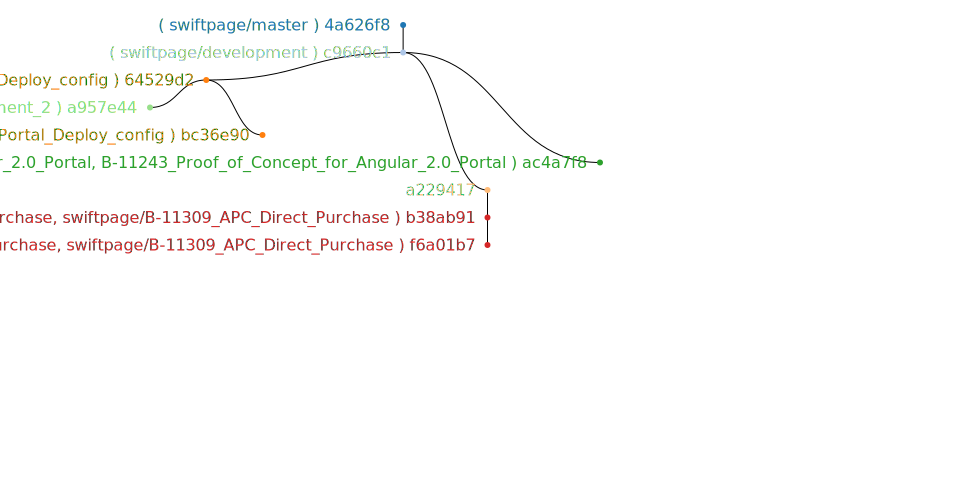

In [74]:
var D3Node = require('d3-node');
var d3n = new D3Node(); // initializes D3 with container element 
var d3 = d3n.d3;

var margin = {top: 25, right: 150, bottom: 25, left: 150},
    width = 960 - margin.left - margin.right,
    height = 500 - margin.top - margin.bottom;

var PROFILE_PATH = process.env.HOME || process.env.HOMEPATH || process.env.USERPROFILE;
var project = PROFILE_PATH + '/Documents/portal';
process.chdir(project)
var execSync = require('child_process').execSync;
var branches = execSync('git branch').toString().split(/\s*\n\s*\**\s*/ig);

// reverse git so we can add merges to the "graph" after the branch tree is constructed
var branch = execSync('git log --pretty=format:"%d %h %p" --reverse ' + branches.join(' ')).toString().split(/\s*\n\s*/ig);
var all = []; //execSync('git log --pretty=format:"%h %p" --reverse --all').toString().split(/\s*\n\s*/ig);

var nodeTree = [];
var edges = [];
var first = '';
branch.forEach(b => {
    var commits = ((/\s*\(.*?\)\s*(.+)/ig).exec(b) || [b, b.trim()])[1].trim().split(/\s+/ig);
    commits.forEach(r => {
        if(nodeTree.filter(d => d.name==r).length == 0) {
            if(first == '') {
                first = r;
            }
            nodeTree[nodeTree.length] = {
                name: r,
                index: nodeTree.length,
                branch: ((/\s*\((.*?)\)/ig).exec(b) || [b, ''])[1]
            }
        }
    });
    edges = edges.concat(commits.slice(1)
                         .filter((c, i) => edges.filter(e => e.target == commits[i]).length == 0)
                         .map((c, i) => {
        return {source: c, target:commits[i]}; // -1 because of slice(1)
    }))
});
var allEdges = [];
all.forEach(b => {
    var commits = ((/\s*[^\(]*?\s*(.+)/ig).exec(b) || [b, b.trim()])[1].trim().split(/\s+/ig);
    commits.forEach(r => {
        if(nodeTree.filter(d => d.name==r).length == 0) {
            nodeTree[nodeTree.length] = {
                name: r,
                index: nodeTree.length
            }
        }
    });
    edges = edges.concat(commits.slice(1)
                         .filter((c, i) => edges.filter(e => e.target == commits[i]).length == 0)
                         .map((c, i) => {
        return {source: c, target:commits[i]}; // -1 because of slice(1)
    }));
});

var nodeMap = {};
nodeTree.forEach(function(x) {
    if(typeof x.size == 'undefined') {
        x.size = 1;
    }
    nodeMap[x.name] = x;
});

edges.forEach(function(x) {
    if(typeof nodeMap[x.source].children == 'undefined') {
        nodeMap[x.source].children = [];
    }
    nodeMap[x.source].branch = nodeMap[x.target].branch;
    nodeMap[x.source].children.push(nodeMap[x.target]);
    // return { parent: nodeMap[x.target], source: nodeMap[x.source], target: nodeMap[x.target] };
});

var tree = d3.hierarchy(nodeTree.filter(d => d.name==first)[0], d => d.children);
var root = // partition(
    tree
        .sum(d => 1)
        .sort((a, b) => b.size - a.size || b.value - a.value)
//)
    .descendants();

root.forEach(r => {
    r.name = r.data.name;
    r.index = r.data.index;
    r.branch = r.data.branch;
})

var tree = d3.tree().nodeSize([25, 150]);

var nodes = tree(d3.hierarchy(root[0], d => d.children))
    .descendants();

var links = nodes.slice(1);

var root = {
  name: 'root',
  children: nodes[0],
  hash: null,
  path: null,
  specificity: null,
  handler: null,
  data: {},
  isAux: false,
};
var fill = d3.scaleOrdinal(d3.schemeCategory20);
var svg = d3n.createSVG(width + margin.left + margin.right,
                       height + margin.top + margin.bottom)
var g = svg.append("g");

var x = d3.scaleLinear().range([0, height]);
var y = d3.scaleLinear().range([0, width]);

x.domain([d3.min(nodes, function(d) { return d.x; }), d3.max(nodes, function(d) { return d.x; })]);
y.domain([d3.min(nodes, function(d) { return d.y; }), d3.max(nodes, function(d) { return d.y; })]);

g.selectAll('.link')
  .data(links)
  .enter().append('path')
    .attr('class', 'link')
    .attr('fill', 'none')
    .attr("stroke", "#000")
    .attr('d', d => `
        M${x(d.x)},${y(d.data.index*25)}
        C${x((d.x + d.parent.x) / 2)},
          ${y(d.data.index*25)} ${x((d.x + d.parent.x) / 2)},
          ${y(d.parent.data.index*25)} ${x(d.parent.x)},
          ${y(d.parent.data.index*25)}`);

// Declare the nodes
var node = g.selectAll('g.node')
  .data(nodes)
  .enter().append('g')
  .attr('class', 'node')
  .style("fill", function(d, i) { return fill(d.data.branch); })
  .attr('transform', d => `translate(${x(d.x)},${y(d.data.index*25)})`);

node.append('circle')
  .attr('class', d => (d.data).isAux ? 'node-aux-route' : 'node-route')
  .attr('r', 3);

node.append('text')
  .attr('x', (d) => -13)
  .attr('dy', '.35em')
  .attr('text-anchor', 'end')
  .text(d => (d.data.branch ? (' ( ' + d.data.branch + ' ) ') : '') + (d.data).name)
  .attr('class', 'monospace');

// reset transform
g.attr('transform', 'translate(0, 0)');

g.attr("transform",
    "translate(" + (margin.left) + "," + (margin.top) + ")")

$$.svg(d3n.svgString());


In [ ]:
'hit';